In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

from typing import Generator

根据带噪声的线性模型构造数据集。使用线性模型参数w = [2, -3.4]<sup>T</sup>、b = 4.2和噪声项$\epsilon$生成数据集和标签

$$
y = Xw + b + \epsilon
$$

In [2]:
def synthetic_data(w, b, num_examples):
    """生成样本和标签。

    Args:
        w (_type_): _description_
        b (_type_): _description_
        num_examples (_type_): 取样本的数量
    """

    # 取均值为0标准差为1的随机数，列数和w一致，用其假设为训练数据样本
    X = torch.normal(0, 1, (num_examples, len(w)))
    # y = Xw + b
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)

    return X, y.reshape((-1, 1))

In [3]:
# 真实的权重
true_w = torch.tensor([2, -3.4])
# 真实的偏差
true_b = 4.2
# 通过权重和偏差生成样本和标注
features, labels = synthetic_data(true_w, true_b, 1000)

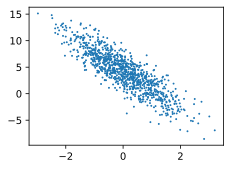

In [4]:
#展示
d2l.set_figsize()
d2l.plt.scatter(
    features[:, 1].detach().numpy(),
    labels.detach().numpy(), 1)

In [5]:
def data_iter(batch_size:int, features:torch.Tensor, labels:torch.Tensor) \
    -> Generator[tuple[torch.Tensor, torch.Tensor], None, None]:
    """生成器，每次调用会返回指定数目随机的样本和标注。

    Args:
        batch_size (int): 指定生成的条数
        features (torch.Tensor): 样本。
        labels (torch.Tensor): 样本的标注

    Yields:
        Generator[tuple[torch.Tensor, torch.Tensor], None, None]: 随机挑选的样本和样本标注。
    """

    num_exaples:int = len(features)
    indices:list[int] = list(range(num_exaples))
    # random.shuffle(indices)

    for i in range(0, num_exaples, batch_size):
        batch_indices = torch.tensor(indices[i:i+batch_size])
        # yield batch_indices
        yield features[batch_indices], labels[batch_indices]

定义模型

In [6]:
def linreg(X, w, b) -> torch.Tensor:
    """线性回归模型

    Args:
        X (torch.Tensor): 影响的因素
        w (torch.Tensor): 每个因素的权重参数
        b (torch.Tensor): 偏差参数

    Returns:
        torch.Tensor: 模型的计算结果
    """
    return torch.matmul(X, w) + b

定义损失函数

In [7]:
def squared_loss(y_hat, y) -> torch.Tensor:
    """均方损失，为了防止y的形状不一致
    所以用y.reshape把它变成y_hat一样的形状

    Args:
        y_hat (torch.Tensor): 计算出来的房价估价
        y (torch.Tensor): 房价真实价格

    Returns:
        torch.Tensor: 损失函数的结果，越小越好。
    """
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

定义优化算法

In [8]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降

    Args:
        params (_type_): _description_
        lr (_type_): 学习率
        batch_size (_type_): 批量大小
    """

    # 不需要在梯度下降里计算梯度。
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

定义初始化的模型参数

In [9]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义超参数

In [10]:
lr = 0.03 # 学习率
num_epochs = 3 #扫三遍数据
batch_size = 100 #单次批量数
net = linreg # 模型
loss = squared_loss #损失

开始训练

In [11]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size=batch_size, features=features, labels=labels):
        y_hat = net(X, w, b)
        l = loss(y_hat=y_hat, y=y)
        l.sum().backward()
        sgd([b], lr, batch_size)
    with torch.no_grad():
        # 这是loss和上面那个loss的区别是，这个是整个样本
        train_l = loss(net(features, w, b), labels)
        print(f'epoch: {epoch + 1}, loss: {float(train_l.mean()):f}')

epoch: 1, loss: 12.046728
epoch: 2, loss: 9.926365
epoch: 3, loss: 8.772928
